# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

Faces from small_img.zip
Results found in file a-0.png


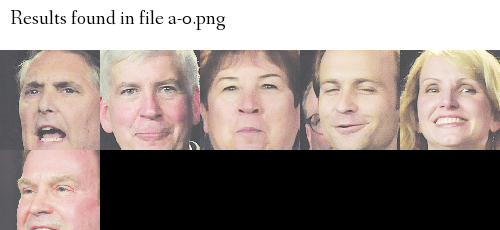

In [ ]:
import zipfile
import sys
from zipfile import ZipFile
from PIL import ImageFont
from PIL import Image 
from PIL import ImageDraw
import numpy as np
import pytesseract
import cv2
# import PIL

# loading the face detection classifier
face_cascade = cv2.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('readonly/haarcascade_eye.xml')

# the rest is up to you!

def face_scraper(zipfile, targetText):
    with ZipFile("readonly/" + zipfile, "r") as archive:
        #Loop through each images in a given Zip file
        for entry in archive.infolist():
            with archive.open(entry) as file:
                
                #Open Image
                image_file = Image.open(file)
#                 print("Opening . . .", file.name)
                
                #Convert image to numpy array
                image = np.asarray(image_file)
#                 #Save as the image to convert to nump Array
#                 image_file.save(file.name, dpi=(10000,10000))
#                 image = cv2.imread(file.name)

                #Apply transformations to the image
    
                #Convert to grayscale
#                 print("Image Transformation")
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (3,3), 0)
                thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
                invert = 255 - thresh

    #           # Morph open to remove noise and invert image
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
                opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
                invert = 255 - opening

#               Perform text extraction using pytesseract
#                 newspaperText = pytesseract.image_to_string(invert, lang='eng', config='--psm 6')
                newspaperText = pytesseract.image_to_string(invert)
    
                #Check if targetText is in newspaperText
#                 print("Checking if the text exist in the image")
                if targetText in newspaperText:
                    drawing=ImageDraw.Draw(image_file)

    #                 faces = face_cascade.detectMultiScale(image, scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))
    #                 faces = face_cascade.detectMultiScale(invert, scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))
                    #Extract images from the image
#                     faces = face_cascade.detectMultiScale(invert, scaleFactor=1.05,minNeighbors=50,minSize=(30, 30))
                    faces = face_cascade.detectMultiScale(image, scaleFactor=1.05,minNeighbors=50,minSize=(30, 30))
#                     faces = face_cascade.detectMultiScale(invert, scaleFactor=1.3,minNeighbors=50)
                    
                    #Count the extracted images
                    faceCount = len(faces)
                
                    if faceCount > 0:
                        print("Results found in file", file.name)
                        faceImagesList = []
                        for rec in faces:
                            faceImage = image_file.crop((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3]))
                    
                            #Set uniform size
#                             newsize = (300, 300) 
                            newsize = (200, 200)
                            faceImage = faceImage.resize(newsize) 
                            faceImagesList.append(faceImage)

                        # create a contact sheet 
                        first_image=faceImagesList[0]

                        if faceCount < 6:
                            height = first_image.height
                            contact_sheet=Image.new(first_image.mode, (first_image.width*5,height))
                        elif faceCount >= 6 and faceCount < 12:
                            height = first_image.height*2
                            contact_sheet=Image.new(first_image.mode, (first_image.width*5,height))
                            
                        #Initial location of the first image
                        x=0
                        y=0

                        for img in faceImagesList:
                            # Lets paste the current image into the contact sheet
                            contact_sheet.paste(img, (x, y) )
                            # Now we update our X position. If it is going to be the width of the image, then we set it to 0
                            # and update Y as well to point to the next "line" of the contact sheet.
                            if x+first_image.width == contact_sheet.width:
                                x=0
                                y=y+first_image.height
                            else:
                                x=x+first_image.width

                        # resize the height and width of the contact sheet
                        contract_sheet_width = contact_sheet.width/2
                        contract_sheet_height = contact_sheet.height/2
                        
                        #resize contract sheet
                        contact_sheet = contact_sheet.resize((int(contract_sheet_width),int(contract_sheet_height) ))

                        #make a blank image for the text,
                        ImageTxt = Image.new("RGBA", (int(contract_sheet_width),int(contract_sheet_height) + 30),  (255,255,255))
                        
                        #Set font and font size
                        fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 20)
                        d = ImageDraw.Draw(ImageTxt)
                        d.text((10,10), "Results found in file " + file.name,font=fnt, fill=(0,0,0))
                        
                        #Paste the contract sheet in the Image Txt
                        ImageTxt.paste(contact_sheet,(0,50))
                        
                        #Display the Contract Sheet with Desciption on top
                        display(ImageTxt)
                    
                    #If no image found in the image but the target text is found
                    else:
                        print("Results found in file " + file.name + "\n" + "But there were no faces in that file!")
                        contract_sheet_width = 600
                        #make a blank image for the text,
                        ImageTxt = Image.new("RGBA", (int(contract_sheet_width), 50),  (255,255,255))
                        fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 20)
                        d = ImageDraw.Draw(ImageTxt)
                        d.text((10,10), "Results found in file " + file.name + "\n" + "But there were no faces in that file!",font=fnt, fill=(0,0,0))
                        display(ImageTxt)
                else:
                    continue

print("Faces from small_img.zip")
face_scraper("small_img.zip", "Christopher")

print("Faces from images.zip")
face_scraper("images.zip", "Mark")

In [ ]:
from zipfile import ZipFile
from PIL import Image
with ZipFile("readonly/images.zip", "r") as archive:
    #Loop through each images in a given Zip file
    imageList = []
    for entry in archive.infolist():
        with archive.open(entry) as file:
            imageList.append(str(file))
        for img in imageList:
            image_file = Image.open(img)
